<a href="https://colab.research.google.com/github/gtmray/gesture_controlled_gaming/blob/main/object_detection_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/gtmray/gesture_controlled_gaming.git

Cloning into 'gesture_controlled_gaming'...
remote: Enumerating objects: 13010, done.
remote: Counting objects: 100% (4651/4651), done.
remote: Compressing objects: 100% (4610/4610), done.
remote: Total 13010 (delta 42), reused 4641 (delta 34), pack-reused 8359
Receiving objects: 100% (13010/13010), 111.98 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Checking out files: 100% (13611/13611), done.


In [2]:
# Importing required packages

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# Enable GPU

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
train_path = '/content/gesture_controlled_gaming/Data/Train'
valid_path = '/content/gesture_controlled_gaming/Data/Val'
test_path = '/content/gesture_controlled_gaming/Data/Test'
B_SIZE = 10
target_width = 200
target_height = 300

# Preprocess using vgg16 preprocess function
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(target_width, target_height), classes=['Up', 'Down', 'Left', 'Right'], batch_size = B_SIZE)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(target_width, target_height), classes=['Up', 'Down', 'Left', 'Right'], batch_size = B_SIZE)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size=(target_width, target_height), classes=['Up', 'Down', 'Left', 'Right'], batch_size = B_SIZE, shuffle=False)

Found 12000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [5]:
# MODEL NO. 1

"""CREATING A CNN MODEL"""

model = Sequential([
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(target_width, target_height, 3)),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    BatchNormalization(),
                    Dropout(0.5),
                    Conv2D(filters=124, kernel_size=(3, 3), activation='relu', padding='same'),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    BatchNormalization(),
                    Dropout(0.5),
                    Flatten(),
                    Dense(units=4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 300, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 150, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 150, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 100, 150, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 150, 124)     71548     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 75, 124)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 75, 124)       4

In [6]:
"""TRAINING THE MODEL"""


checkpoint_path = 'checkpoint/cp.ckpt'

# Callback to save models weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1) 


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_batches ,validation_data=valid_batches, epochs=5, verbose=1, callbacks = [cp_callback], use_multiprocessing=True)
model.save('model.h5')

Epoch 1/5
1200/1200 [==============================] - 132s 86ms/step - loss: 2.4558 - accuracy: 0.9664 - val_loss: 247.7097 - val_accuracy: 0.6175

Epoch 00001: saving model to checkpoint/cp.ckpt
Epoch 2/5
1200/1200 [==============================] - 102s 85ms/step - loss: 0.8317 - accuracy: 0.9915 - val_loss: 22.5939 - val_accuracy: 0.8800

Epoch 00002: saving model to checkpoint/cp.ckpt
Epoch 3/5
1200/1200 [==============================] - 104s 86ms/step - loss: 0.4301 - accuracy: 0.9962 - val_loss: 32.9423 - val_accuracy: 0.8650

Epoch 00003: saving model to checkpoint/cp.ckpt
Epoch 4/5
1200/1200 [==============================] - 102s 85ms/step - loss: 0.5634 - accuracy: 0.9957 - val_loss: 36.9812 - val_accuracy: 0.8838

Epoch 00004: saving model to checkpoint/cp.ckpt
Epoch 5/5
1200/1200 [==============================] - 102s 85ms/step - loss: 0.2183 - accuracy: 0.9977 - val_loss: 21.4598 - val_accuracy: 0.9025

Epoch 00005: saving model to checkpoint/cp.ckpt


In [7]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def accuracy(model, history):
  preds = model.predict(x=test_batches)
  y_preds = np.argmax(preds, axis=-1)
  y_true = test_batches.classes
  accuracy = accuracy_score(y_true, y_preds)
  print(f"Accuracy in test batches is : {accuracy*100}")

  plt.plot(history.history['accuracy'], label='Training accuracy')
  plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

In [8]:
# Visualization of CNN model and prediction

import numpy as np
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input


def preprocess_new_img(image_dir, img_width, img_height):
  '''
    Converts a single image to image format accepted in keras
  '''
  img = image.load_img(image_dir, target_size = (img_width, img_height))
  img = image.img_to_array(img)
  #plt.imshow(img/255.)
  img = np.expand_dims(img, axis = 0) # Convert to batches
  img = preprocess_input(img) # According to vgg16 preprocess

  return img

def predict(model_dir, image_dir):
  
  '''
      Predict the image from the directory
  '''
  model_loaded = load_model(model_dir)
  img = preprocess_new_img(image_dir, target_width, target_height)
  result = np.argmax(model_loaded.predict(img), axis=-1)[0]

  if result == 0:
    print("UPPPPP")
  elif result == 1:
    print("Down")
  elif result == 2:
    print("Leftt")
  else:
    print("Right")

In [9]:
import tensorflow.keras.backend as K
import cv2
from google.colab.patches import cv2_imshow


def cnn_visualization(img, model, last_conv_name):
    
  # Grad cam technique

  with tf.GradientTape() as tape:
    _, w, h, _ = model.get_layer(last_conv_name).output_shape # Get width and height for heatmap
    last_conv_layer = model.get_layer(last_conv_name)
    output_and_conv = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    output, last_conv_layer = output_and_conv(img)
    highest_class_out = output[:, np.argmax(output[0])] # Output of highest class
    dy_dx = tape.gradient(highest_class_out, last_conv_layer) # Gradient of highest class ouput with respect to last convolutional layer
    pooled_dy_dx = K.mean(dy_dx, axis=(0, 1, 2)) # Mean of the gradient , 124 shaped
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_dy_dx, last_conv_layer), axis=-1)

  heatmap = np.maximum(heatmap, 0) # Disgard all negative values
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((w, h))

  return heatmap

def apply_to_img(image_dir, heatmap, intensity=0.6):
  
  # Superimpose the heatmap on original image
  org_img = cv2.imread(image_dir)
  heatmap = cv2.resize(heatmap, (org_img.shape[1], org_img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img = heatmap * intensity + org_img
  
  return img

Accuracy in test batches is : 85.125
UPPPPP


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


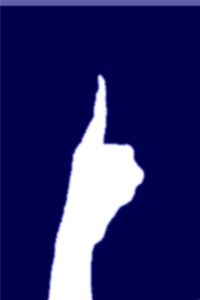

Down


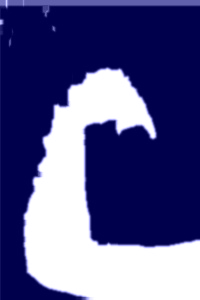

Leftt


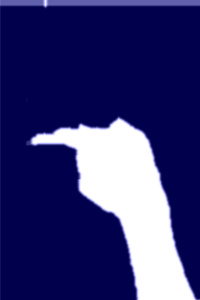

Down


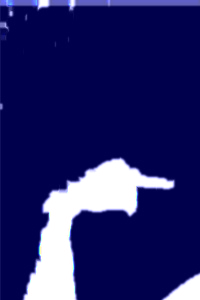

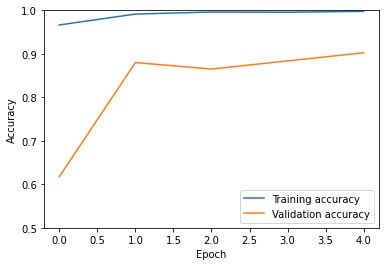

In [10]:
import os
import random

model_dir = '/content/model.h5'
conv_layer = model.layers[-6].name
model_custom = load_model(model_dir)


def random_images(size_per_class=1):
  '''
    Generate random images from each classes
  '''
  images_path = []
  classes = ['Up', 'Down', 'Left', 'Right']
  for i in classes:
    test_path = '/content/gesture_controlled_gaming/Data/Test/' + i +'/'
    images = random.sample(os.listdir(test_path), size_per_class)
    images_path.append(test_path+images[0]) 
  
  return images_path

images_path = random_images(size_per_class=1)

accuracy(model_custom, history)
# To show random images with their visualization
for dir in images_path:

  img = preprocess_new_img(dir, target_width, target_height)
  predict(model_dir, dir)
  hm = cnn_visualization(img, model, conv_layer)
  super_img = apply_to_img(dir, hm)
  cv2_imshow(super_img)


In [11]:
# VGG16 model

target_width = 224
target_height = 224
B_SIZE = 10

# Preprocess using vgg16 preprocess function
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(target_width, target_height), classes=['Up', 'Down', 'Left', 'Right'], batch_size = B_SIZE)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(target_width, target_height), classes=['Up', 'Down', 'Left', 'Right'], batch_size = B_SIZE)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size=(target_width, target_height), classes=['Up', 'Down', 'Left', 'Right'], batch_size = B_SIZE, shuffle=False)

vgg16_model = tf.keras.applications.vgg16.VGG16()

model_vgg16 = Sequential()
for layer in vgg16_model.layers[:-1]: #Except last layer
  model_vgg16.add(layer)

for layer in model_vgg16.layers: #Avoiding training layers
  layer.trainable=False

model_vgg16.add(Dense(units=4, activation='softmax')) #Adding custom last layer
model_vgg16.summary()

Found 12000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
553467904/553467096 [==============================] - 14s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [12]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg16 = model_vgg16.fit(x=train_batches, validation_data=valid_batches, epochs=1, verbose=1)
model_vgg16.save('model_VGG.h5')

1200/1200 [==============================] - 172s 139ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0577 - val_accuracy: 0.9712


Accuracy in test batches is : 99.875


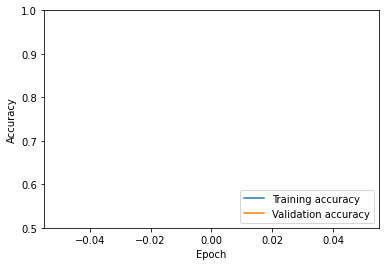

In [13]:
accuracy(model_vgg16, history_vgg16)

UPPPPP


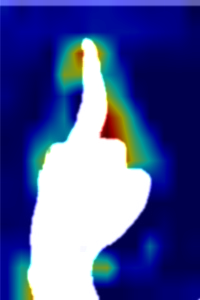

Down


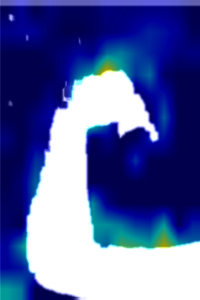

Leftt


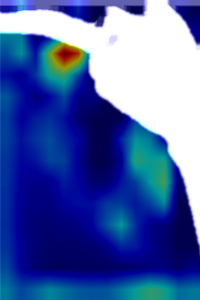

Right


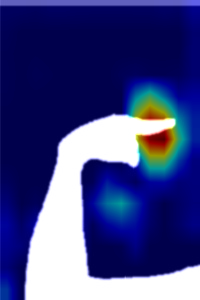

In [14]:
from tensorflow.keras import layers


# To show random images with their visualization

model_dir = 'model_VGG.h5'
md = load_model(model_dir)
conv_layer = md.layers[-6].name

images_path = random_images(size_per_class=1)

for dir in images_path:

  img = preprocess_new_img(dir, target_width, target_height)
  predict(model_dir, dir)
  hm = cnn_visualization(img, md, conv_layer)
  super_img = apply_to_img(dir, hm)
  cv2_imshow(super_img)


In [15]:
# Mobile Net
from tensorflow.keras import Model
from keras.applications.mobilenet import preprocess_input

target_width = 224
target_height = 224
B_SIZE = 10
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=B_SIZE)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=B_SIZE)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=B_SIZE, shuffle=False)

mobile = tf.keras.applications.mobilenet.MobileNet()
# mobile.summary()
x = mobile.layers[-6].output
output = Dense(units=4, activation='softmax')(x)
model_mobile = Model(inputs=mobile.input, outputs=output)


Found 12000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
17227776/17225924 [==============================] - 1s 0us/step


In [16]:
for layer in model.layers[:-23]:
  layer.trainable=False
model_mobile.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_mobile = model_mobile.fit(x=train_batches, validation_data=valid_batches, epochs=1, verbose=1)
model_mobile.save('mobile_model.h5')

1200/1200 [==============================] - 146s 119ms/step - loss: 0.0207 - accuracy: 0.9934 - val_loss: 6.2957e-07 - val_accuracy: 1.0000


Accuracy in test batches is : 100.0


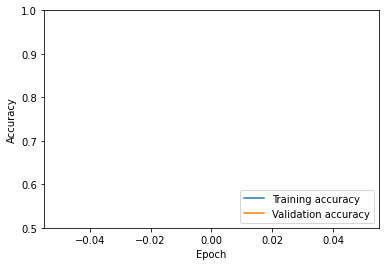

In [17]:
accuracy(model_mobile, history_mobile)